## Setup

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 17.5MB/s 
     |████████████████████████████████| 1.2MB 55.6MB/s 
     |████████████████████████████████| 194kB 56.9MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
     |████████████████████████████████| 12.8MB 233kB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [3]:
from fastbook import *

## Data

In [5]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [6]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


## Contructing Datablock

In [7]:
dblock = DataBlock()
dsets = dblock.datasets(df)

In [8]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [10]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [38]:
def get_x(r): return path/'train'/r['fname']

def get_y(r): return r['labels'].split(' ') 

def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    get_x = get_x,
    get_y= get_y,
    splitter = splitter,
    item_tfms = RandomResizedCrop(128, min_scale=0.35)
    )

dls = dblock.dataloaders(df)

## Binary Cross Entropy

In [39]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [40]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [41]:
activs[0]

tensor([-0.3331,  6.4825, -0.8776,  3.3945,  1.2616, -0.6367, -2.1945,  4.4255,  0.3934, -1.1779,  0.7778,  1.5323,  4.4392, -0.6144, -1.3245, -2.5475,  2.8060, -5.6149, -2.2486, -3.4112],
       grad_fn=<SelectBackward>)

In [42]:
learn = cnn_learner(dls, resnet50, metrics=accuracy_multi)
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.946299,0.704996,0.621693,00:29
1,0.822475,0.553829,0.737729,00:29
2,0.603116,0.206038,0.947948,00:29
3,0.359236,0.125779,0.956594,00:29


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.135223,0.112911,0.959681,00:30
1,0.116320,0.104397,0.963625,00:30
2,0.097913,0.101068,0.963825,00:30


## Regression

In [46]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [50]:
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [51]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

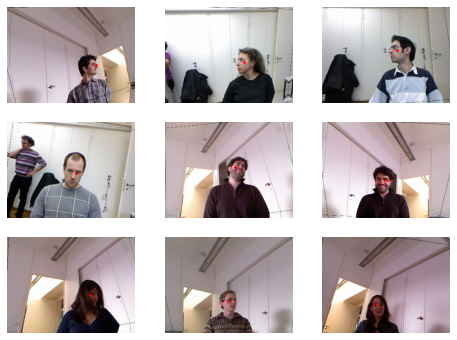

In [52]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [53]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [55]:
yb[0], yb[0].shape

(TensorPoint([[-0.2822, -0.0507]], device='cuda:0'), torch.Size([1, 2]))

In [62]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=1.5848931980144698e-06)

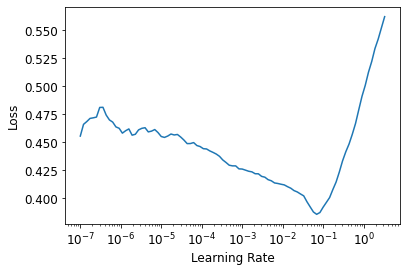

In [63]:
learn.lr_find()

In [64]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.047993,0.005739,02:04


epoch,train_loss,valid_loss,time
0,0.007997,0.007978,02:15
1,0.003115,0.000143,02:14
2,0.001527,0.000116,02:16


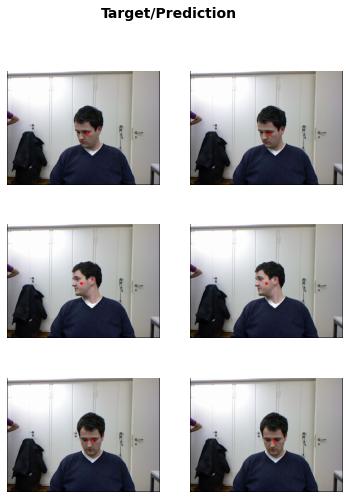

In [65]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))